In [1]:
%matplotlib inline
import sys
sys.path.append("/Users/edwardlrichards/compAcoustics") 
sys.path.append("/Users/edwardlrichards/swellEx") 

import numpy as np
import pandas as pd
import matplotlib.pylab as plt
import datetime as d
from scipy import signal
from sklearn.linear_model import Lasso, Ridge

import swellEx_env
from normalMode import Chinook
from beamformers import bartlet
from beamformers import wnc_bisection as wnc
import loadSIO as sio

# Step by step matched field

In [2]:
# Experimental data
dataFile = '/Users/edwardlrichards/swellEx/data/J1312315.vla.21els.sio'
fs = 1500
# tStart = 1980
tStart = 3820

snapLength = 2
snapStep = 2
numSnaps = 23
sD = 54

wncMaxNorm = 2

frequencies = [49, 64, 79, 94, 112, 130, 148, 166, 201, 235, 283, 338, 388]
frequencyNumber = 0
testFreq = frequencies[frequencyNumber]
tol = 1

year = str(1996)
experimentStart = d.datetime.strptime(year + 'J1312315',\
                                      '%YJ%j%H%M')
rangeTime = experimentStart + d.timedelta(0, tStart)
sourceRange = swellEx_env.getRangeAtTime(rangeTime)
print(sourceRange)

1.097


In [3]:
enviornment = swellEx_env.loadEnviornment(ctdNumber = 6)
sensorPosition = swellEx_env.loadArray(flipArray=True)
numSensors = sensorPosition.size
# Match field boundries
# zMax = enviornment.getProfile(0.).getZatInterface()[1]
zMax = 100

rMax = 1.5e3  # m
rMin = 500
numR = 60
numZ = 50

# Solver Parameters
decimation = 10
fB_width = 300

In [4]:
# load data file
sampleStart = tStart * fs
numSamples = (snapLength + (snapStep * numSnaps)) * fs
channels = -1
data = sio.load_selection(dataFile, sampleStart, numSamples, channels,\
        channelNames = sensorPosition)

In [5]:
zPlot = np.r_[0:zMax:numZ * 1j]
rPlot = np.r_[rMin:rMax:numR * 1j]
R_nm, Z = np.meshgrid(rPlot, zPlot)

In [6]:
# Synthetic data set
nm_model = Chinook(frequencies[frequencyNumber], enviornment)
nm_model.calculateModes_eig(fB_width, decimation)
p = nm_model.calculatePressure(sD, sensorPosition.values, sourceRange * 1e3)
p = np.squeeze(p)
K = np.outer(p, np.conj(p))

In [7]:
# Make normalized look vectors
lookVectors = [nm_model.calculatePressure(d, zPlot, rPlot) for d in sensorPosition]
W = np.dstack(lookVectors)
W = W / np.linalg.norm(W, axis = 2)[:,:,None]
W = np.nan_to_num(W)
W = np.reshape(W, (numR * numZ, numSensors))

In [39]:
# setup for L1 minimization
X = W.T.conj()
numLook = X.shape[1]
XSplit = np.vstack((np.hstack((X.real, X.imag)),\
                    np.hstack((-X.imag, X.real))))

Y = p
YSplit = np.hstack((np.vstack((Y.real, Y.imag)),\
                    np.vstack((-Y.imag, Y.real)))).T

lamb = 0

In [9]:
def reshape_DB(W):
    """convience function for reshaping and plotting on dB"""
    B = np.reshape(W, (numR, numZ))
    B = 10 * np.log10(np.abs(B) + np.spacing(1))
    B = B - np.max(B)
    return B

In [10]:
def unstack_dB(solverOutput):
    """Unstack the messy output of a ML solver, and put into dB"""
    stack = solverOutput.coef_[::2,:]
    stack = stack[:,:numLook] + 1j * stack[:,numLook:]
    stack = np.linalg.norm(stack, 2, axis = 0)
    stack = np.nan_to_num(stack)
    B = reshape_DB(stack)
    return B

In [40]:
B_bart = reshape_DB(bartlet(K, W))

In [50]:
# bart = [np.abs(np.dot(p, look)) ** 2 for look in X.T]
bart = [np.dot(p, look) for look in X.T]

B_bart = np.abs(np.array(bart)) ** 2
B_bart = reshape_DB(B_bart)

In [42]:
W_ls_reg = np.linalg.lstsq(X.conj().T.dot(X) + lamb * np.identity(numLook), X.conj().T.dot(Y))

In [45]:
W_ls = np.linalg.lstsq(X, Y)

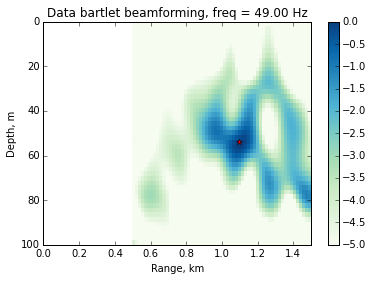

In [25]:
_ = plt.figure(0)
_ = plt.clf()
_ = plt.pcolormesh(R_nm / 1e3, Z, np.array(B_bart).T, cmap = plt.cm.GnBu)
_ = plt.clim(-5, 0)
_ = plt.colorbar()
_ = plt.xlim(0, rMax / 1e3)
_ = plt.ylim(zMax,0)
_ = plt.title('Data bartlet beamforming, freq = %0.2f Hz' %testFreq)
_ = plt.plot(sourceRange, sD, 'r*')
_ = plt.ylabel('Depth, m')
_ = plt.xlabel('Range, km')

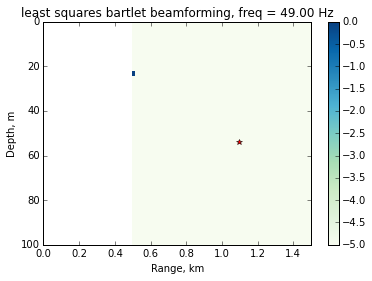

In [43]:
B_ls_reg = reshape_DB(np.abs(W_ls_reg[0]) ** 2)

_ = plt.figure(1)
_ = plt.clf()
_ = plt.pcolormesh(R_nm / 1e3, Z, np.array(B_ls_reg).T, cmap = plt.cm.GnBu)
_ = plt.clim(-5, 0)
_ = plt.colorbar()
_ = plt.xlim(0, rMax / 1e3)
_ = plt.ylim(zMax,0)
_ = plt.title('least squares bartlet beamforming, freq = %0.2f Hz' %testFreq)
_ = plt.plot(sourceRange, sD, 'r*')
_ = plt.ylabel('Depth, m')
_ = plt.xlabel('Range, km')

In [52]:
print(np.sum(np.abs(bart)) ** 2)
print(np.sum(np.abs(W_ls[0])) ** 2)

240.208586361
0.00545349139961


In [55]:
#cost of solutions
cost1 = np.linalg.norm(np.dot(X.conj(), bart) - Y, 2)
cost2 = np.linalg.norm(np.dot(X.conj(), W_ls[0]) - Y, 2)
print(cost1)
print(cost2)

9.53849868351
0.0146571392627


In [16]:
# lasso_solver = Lasso(alpha=alpha, max_iter=1e4)